In [1]:
display("text/html", "<style>.container { width:100% !important; }</style>")

In [38]:
using Plots
using Distributed
using LinearAlgebra

num_cores = length(Sys.cpu_info())
println("num_cores=$(num_cores)")
if nprocs()==1
    addprocs(num_cores; exeflags=`--project=$(Base.active_project())`)
end

@everywhere begin
    using LatticeAlgorithms
    using LinearAlgebra
    using Dates
    using BlockDiagonals
end
using JLD2

num_cores=96


In [31]:
type_lattice = "color_square"
χ = 128

# dmin, dmax = 3, 39
# σrange = vcat(0.50:0.01:0.59, 0.591:0.001:0.607, exp(-1/2))

dmin, dmax = 3, 5
σrange = vcat(0.50:0.01:0.59, 0.591:0.001:0.607)


drange = dmin : 2 : dmax
σdrange = []
for σ in σrange
    for d in drange
        push!(σdrange, [σ, d])
    end
end

num_samples = Int(1e7)

num_samples_each_core = Int(ceil(num_samples/num_cores))
num_total_samples = Int(num_samples_each_core * num_cores);
println([num_samples_each_core, num_samples, num_total_samples])

logfile = "tn_$(type_lattice)_$(min(σrange...))_$(max(σrange...))_$(num_total_samples)_log.txt"
    open(logfile, "w") do file
end

[104167, 10000000, 10000032]


In [32]:
@time results = pmap(1:num_cores) do _

    p_list = Dict(σdrange.=>[0.0 for _ in 1 : length(σdrange)])
    t_list = Dict(σdrange.=>[0.0 for _ in 1 : length(σdrange)])
    f_list = Dict(σdrange.=>[0.0 for _ in 1 : length(σdrange)])
    truncs = Dict(σdrange.=>[0.0 for _ in 1 : length(σdrange)])

    for (ind_σd, σd) in enumerate(σdrange)
        σ, d = σd[1], Int(σd[2])
        
        M0 = triangular_color_code_M(d)
        M = M0
        Mperp = GKP_logical_operator_generator(M)            
        Ω = Ω_matrix(M)
        invtransposeMq = inv(transpose(M))[1:2:end, 1:2:end] 
                    
        TN, indices = tn_template_color_square(d)
        logical = triangular_color_code_logicals(d)[1]
                
        pp = 0.0
        tt = 0.0
        fail = 0.0
        num_truncs = 0.0
        σdtime = @elapsed for _ in 1 : num_samples_each_core
            ξ = σ * randn(2 * triangular_color_code_num_qubits(d))
            
            # if d == 23
            #     setprecision(BigFloat, 64)
            #     ξ = BigFloat.(ξ)                    
            # end                
                
            ξ2 = -√(2π) * M * Ω * ξ
            s = ξ2 - floor.(ξ2/(2π)) * 2π
            ηs = -transpose(Ω*Mperp) * s/√(2π) ; 
            b = inv(√(2π) * transpose(Mperp)) * (ηs-ξ)
            # @assert norm(round.(Int, b) - b) < 1e-10

            tt += @elapsed begin
                ηs_q = ηs[1:2:end]
                # setprecision(BigFloat, 64)
                # ηs_q = BigFloat.(ηs_q)                    
                
                # Method 1
                lstar = nothing
                try
                    lstar, prob_I, prob_X, num_truncs_I, num_truncs_X = tn_color_square(ηs_q, σ, logical, TN, indices, χ; Nv=5)
                    num_truncs += num_truncs_I
                catch
                    fail += 1
                end
                lstar == nothing && (lstar = zeros(length(ηs_q)))
                

                # # Method 2
                # lstar_2, prob_I_2, prob_X_2 = tn_color_brute_force(ηs_q, σ, logical, stabilizers[d]; n=5)                    
                # @assert prob_I ≈ log10(prob_I_2)
                # @assert prob_X ≈ log10(prob_X_2)
                # @assert lstar == lstar_2
                
                ########
                rec_q = -(ηs_q - lstar)
                final_error = rec_q + ξ[1:2:end]
                nx = sum(final_error[logical]/√π)
                nx = mod(round(nx), 2)
                @assert round.(Int, nx) ≈ nx
                pp += 1 - nx
                
            end
            
        end

        p_list[[σ, d]] += pp
        t_list[[σ, d]] += tt
        f_list[[σ, d]] += fail
        truncs[[σ, d]] += num_truncs

        if myid() == 2
            # Print the progress of the 2nd worker
            println(["$(ind_σd)/$(length(σdrange)), $d, $(σdtime), $(string(now()))"])
            open(logfile, "a") do file
                write(file, "$(ind_σd)/$(length(σdrange)), $d, $(σdtime), $(string(now()))\n")
            end
        end
    end
    return (p_list, t_list, f_list, truncs)
end ;

p_list = merge(.+, [res[1] for res in results]...)
t_list = merge(+, [res[2] for res in results]...)
f_list = merge(+, [res[3] for res in results]...)
truncs_list = merge(.+, [res[4] for res in results]...)


map!(v->v./num_total_samples, values(t_list))
map!(v->v./num_total_samples, values(p_list))
map!(v->v./num_total_samples, values(f_list))
map!(v->v./num_total_samples, values(truncs_list))

c_list = Dict()

for (k, v) in p_list
    px = v * (1-v)
    pz = px
    py = (1-v)^2
    c_list[k] = coherent_information_pauli_channel(px, py, pz)
end


# Save the result
fn = "tn_$(type_lattice)_$(min(σrange...))_$(max(σrange...))_$(num_total_samples).jld2";
jldsave(fn; 
    σrange=σrange, 
    num_samples=num_samples_each_core*num_cores,
    p_list = p_list,
    t_list = t_list,
    c_list = c_list,
    f_list = f_list,
    trunc_list = truncs_list,
    drange = drange
)


      From worker 2:	["1/54, 3, 96.657765966, 2024-10-13T17:58:01.807"]
      From worker 2:	["2/54, 5, 289.044438784, 2024-10-13T18:02:50.879"]
      From worker 2:	["3/54, 3, 96.261243846, 2024-10-13T18:04:27.143"]
      From worker 2:	["4/54, 5, 286.780127324, 2024-10-13T18:09:13.927"]
      From worker 2:	["5/54, 3, 99.300156068, 2024-10-13T18:10:53.230"]
      From worker 2:	["6/54, 5, 284.618639363, 2024-10-13T18:15:37.855"]
      From worker 2:	["7/54, 3, 100.524440543, 2024-10-13T18:17:18.382"]
      From worker 2:	["8/54, 5, 281.198249849, 2024-10-13T18:21:59.586"]
      From worker 2:	["9/54, 3, 99.183663408, 2024-10-13T18:23:38.771"]
      From worker 2:	["10/54, 5, 281.386557338, 2024-10-13T18:28:20.164"]
      From worker 2:	["11/54, 3, 99.516194231, 2024-10-13T18:29:59.684"]
      From worker 2:	["12/54, 5, 280.325171267, 2024-10-13T18:34:40.039"]
      From worker 2:	["13/54, 3, 99.406326251, 2024-10-13T18:36:19.449"]
      From worker 2:	["14/54, 5, 280.41318962, 2024-1

In [33]:
sort(load(fn))

OrderedCollections.OrderedDict{String, Any} with 8 entries:
  "c_list"      => Dict{Any, Any}([0.51, 5.0]=>0.612397, [0.56, 3.0]=>0.0546119…
  "drange"      => 3:2:5
  "f_list"      => Dict([0.51, 5.0]=>0.0, [0.52, 5.0]=>0.0, [0.56, 3.0]=>0.0, […
  "num_samples" => 10000032
  "p_list"      => Dict([0.51, 5.0]=>0.970118, [0.52, 5.0]=>0.961925, [0.56, 3.…
  "t_list"      => Dict([0.51, 5.0]=>0.00229117, [0.52, 5.0]=>0.00228409, [0.56…
  "trunc_list"  => Dict([0.51, 5.0]=>0.0, [0.52, 5.0]=>0.0, [0.56, 3.0]=>0.0, […
  "σrange"      => [0.5, 0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59  …

# Compare to existing data

In [34]:
function get_p0list_sorted(p_list, drange, σrange)
    p0list_sorted = sort(p_list)
    p0list_sorted = collect(values(p0list_sorted))
    p0list_sorted = reshape(p0list_sorted, (length(drange), length(σrange)))
    p0list_sorted = [p0list_sorted[:,i] for i in 1:size(p0list_sorted,2)]
    return p0list_sorted
end


get_p0list_sorted (generic function with 1 method)

In [35]:
new_data = sort(load(fn))
new_p_list = new_data["p_list"]
new_p_list_sorted = get_p0list_sorted(new_p_list, drange, σrange)

27-element Vector{Vector{Float64}}:
 [0.9570172375448398, 0.9770039735872845]
 [0.9491013628756388, 0.970117695623374]
 [0.9404403905907501, 0.9619254218386502]
 [0.9309141210748125, 0.9522801527035113]
 [0.9207271536731082, 0.9413911875481998]
 [0.9100771877529992, 0.9292849262882359]
 [0.898829823744564, 0.9156496699210562]
 [0.8867561623802804, 0.9011984161650682]
 [0.8744003019190338, 0.8855684661809082]
 [0.861814442193785, 0.8689752192792983]
 [0.8605969460897726, 0.8671782250296799]
 [0.8592456504139186, 0.8657284296690251]
 [0.8579021547131049, 0.8637993358421253]
 ⋮
 [0.8541707666535467, 0.8584560529406305]
 [0.8525303719028099, 0.8569093578900547]
 [0.8513745756013581, 0.8550621638010758]
 [0.8500667797863047, 0.8535308687012202]
 [0.8487435840205312, 0.8519807736615242]
 [0.8474078882947574, 0.8498459804928624]
 [0.8463584916528267, 0.8484142850742877]
 [0.8449357962054521, 0.8464338914115475]
 [0.8436086004524785, 0.844528597508488]
 [0.8422493048022246, 0.8428322029369506]

In [36]:
## 
old_data = sort(load("data/raw_data/color_square_3_21_0.0_2.0_1.0_128_10016000.jld2"))
old_p_list = old_data["p_list"]

old_p_list_d = Dict()
for (k, v) in old_p_list
    if drange[1] <= k[2] <= drange[end]
        old_p_list_d[k] = v
    end
end

old_p_list_sorted = get_p0list_sorted(old_p_list_d, drange, old_data["σrange"])
display(old_p_list_sorted)


20-element Vector{Vector{Any}}:
 [0.9569369009584665, 0.9768887779552715]
 [0.9489872204472843, 0.9700392372204473]
 [0.9402800519169329, 0.9618707068690096]
 [0.9309818290734825, 0.9521872004792332]
 [0.9206670327476039, 0.9414936102236422]
 [0.9101819089456868, 0.929151357827476]
 [0.8986614416932908, 0.915785143769968]
 [0.8867792531948882, 0.9011754193290735]
 [0.8744931110223643, 0.8855703873801917]
 [0.8617660742811502, 0.8689962060702875]
 [0.8605220646964856, 0.8671776158146964]
 [0.8591373801916933, 0.8655772763578274]
 [0.8579394968051118, 0.8639241214057508]
 [0.8565360423322683, 0.8621437699680511]
 [0.8554246206070287, 0.8603799920127796]
 [0.8541800119808307, 0.8587918330670926]
 [0.8526842052715655, 0.8569836261980831]
 [0.8513360623003194, 0.8552018769968052]
 [0.850158446485623, 0.8535593051118211]
 [0.848785642971246, 0.851823981629393]

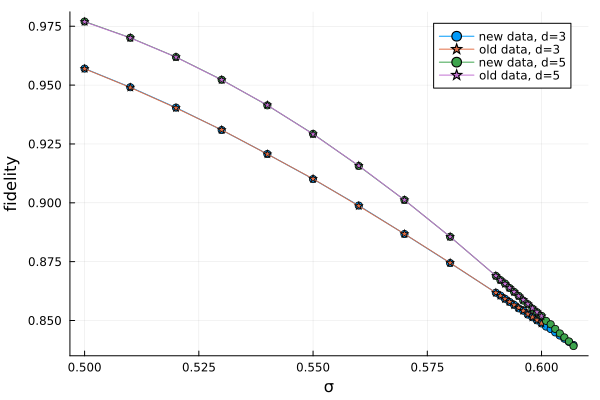

In [37]:
g = plot()

for (dind, d) in enumerate(drange)
    plot!(σrange, [item[dind] for item in new_p_list_sorted], marker=:circle, label="new data, d=$d")
    plot!(old_data["σrange"], [item[dind] for item in old_p_list_sorted], marker=:star, label="old data, d=$d")    
end
plot!(xlabel="σ", ylabel="fidelity")